Rectification: none; working size = 1278x958
Targets (D3..D10, E3..E10):
row  col well  intensity_L
  D    3   D3          3.0
  D    4   D4        126.0
  D    5   D5        122.0
  D    6   D6        107.0
  D    7   D7         73.0
  D    8   D8         47.0
  D    9   D9         47.0
  D   10  D10          2.0
  E    3   E3          2.0
  E    4   E4         34.0
  E    5   E5         25.0
  E    6   E6         23.0
  E    7   E7         96.0
  E    8   E8        139.0
  E    9   E9        110.0
  E   10  E10          2.0

Saved all wells to: well_intensities.csv


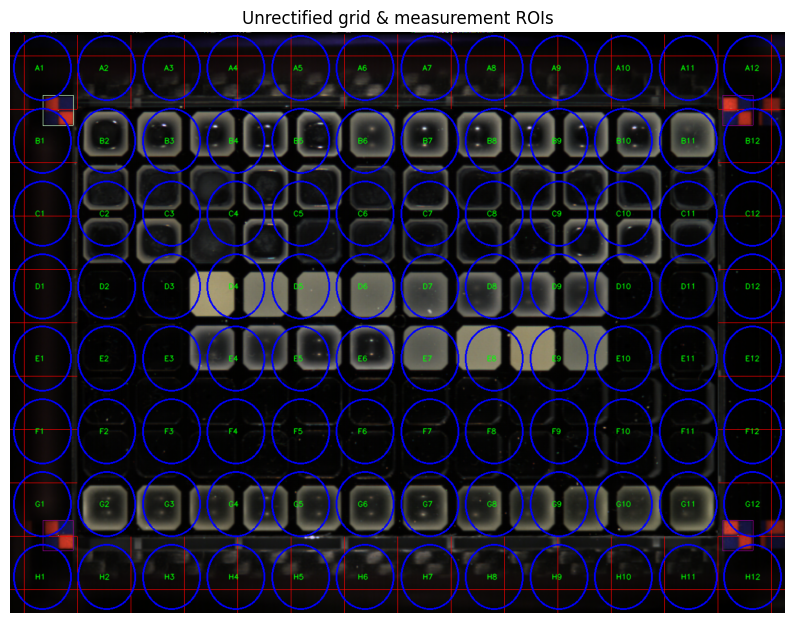

,row,col,well,intensity_L
0,A,1,A1,3.0
1,A,2,A2,7.0
2,A,3,A3,8.0
3,A,4,A4,11.0
4,A,5,A5,14.0


In [15]:
#!/usr/bin/env python3
import cv2
import numpy as np
import pandas as pd

# -------------------------------
# DEFAULT CONFIG (edit as needed)
# -------------------------------

image_path = r"c:\Users\uqkmuroi\gitcode\GrowthProfiler_ML_colorfinder\data\mtp03_20250801_060149.bmp"
DEFAULT_GLARE_DROP_TOP_PCT = 0.1

# Fiducial (red/blue checker) detection in HSV
HSV_RED1 = ((0, 80, 60), (10, 255, 255))       # lower red
HSV_RED2 = ((170, 80, 60), (180, 255, 255))    # upper red
HSV_BLUE = ((100, 80, 60), (135, 255, 255))

FIDUCIAL_MIN_AREA = 200
FIDUCIAL_MAX_CANDIDATES = 20

# Blob detector (center spots) — permissive (rounded squares)
BLOB_MIN_AREA = 200
BLOB_MAX_AREA = 8000
BLOB_MIN_CIRCULARITY = 0.08
BLOB_MIN_INERTIA = 0.08
BLOB_MIN_CONVEXITY = 0.2

N_COLS = 12
N_ROWS = 8

# Inner ROI (ellipse) as fraction of cell size
INNER_SCALE_X = 0.45
INNER_SCALE_Y = 0.45

# ---------------------------------
# Utility functions
# ---------------------------------

def imread(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return img

def order_corners(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)
    rect = np.zeros((4,2), np.float32)
    rect[0] = pts[np.argmin(s)]       # TL
    rect[2] = pts[np.argmax(s)]       # BR
    rect[1] = pts[np.argmin(diff)]    # TR
    rect[3] = pts[np.argmax(diff)]    # BL
    return rect

def get_hsv_masks(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    red1 = cv2.inRange(hsv, np.array(HSV_RED1[0]), np.array(HSV_RED1[1]))
    red2 = cv2.inRange(hsv, np.array(HSV_RED2[0]), np.array(HSV_RED2[1]))
    red = cv2.bitwise_or(red1, red2)
    blue = cv2.inRange(hsv, np.array(HSV_BLUE[0]), np.array(HSV_BLUE[1]))
    return red, blue

# ... (all other utility functions remain unchanged) ...

# ---------------------------------
# Main pipeline
# ---------------------------------

# Use your original process() function as is, no argparse needed

# ---------------------------------
# Run the analysis in Jupyter
# ---------------------------------

df, targets = process(
    image_path,
    "well_intensities.csv",
    show=True,
    debug=True,
    method="auto",
    drop_top_pct=DEFAULT_GLARE_DROP_TOP_PCT
)

# Optional: inspect results
df.head()
